In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import model_selection, feature_extraction,metrics, mixture
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from scipy.optimize import curve_fit
from pylab import *
import seaborn as sns

## 2. SMSSpam

Importing the data

In [2]:
sms = pd.read_csv('/Users/jeandre/Desktop/Applied Machine Learning/Post Block Assignemnt 1/SMSSpamCollection.txt',delimiter="\t",header=None)

some example output, making sure we have the right data

In [3]:
sms

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
target = sms[0]
words = sms[1]

Assign the words and labels to X and Y and perform a test train split for model evaluation.

In [5]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(words,target, test_size = 0.3, random_state = 0)

In [6]:
X_train

4380                 How are you. Just checking up on you
3887    Same, I'm at my great aunts anniversary party ...
4755                   Ok lor... Or u wan me go look 4 u?
2707    S now only i took tablets . Reaction morning o...
4747           Orh i tot u say she now still dun believe.
                              ...                        
4931    Hi, the SEXYCHAT girls are waiting for you to ...
3264                              So u gonna get deus ex?
1653    For ur chance to win a £250 cash every wk TXT:...
2607    R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...
2732    Mm feeling sleepy. today itself i shall get th...
Name: 1, Length: 3900, dtype: object

Fitting a count vectorizer on the training data and then passing the test data through so that they share the same vocab.


In [7]:
Y_train
count_vect = sklearn.feature_extraction.text.CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
values = Y_train.unique()

In [8]:
nb = MultinomialNB()
nb.fit(X_train_counts,Y_train)
N_pred = nb.predict(X_test_counts)
metrics.accuracy_score(Y_test, N_pred)

0.986244019138756

Good initial accuracy metric, looking at the confusion matrix we see the pereformance on ham is much better than performance on spam. 

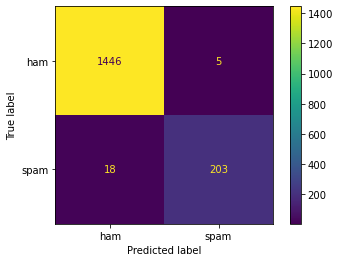

In [9]:
metrics.plot_confusion_matrix(nb,X_test_counts,Y_test,display_labels=values) 

## 3. GaussianMix

In [10]:
gauss  = pd.read_csv('/Users/jeandre/Desktop/Applied Machine Learning/Post Block Assignemnt 1/GaussianMix.csv')

In [11]:
gauss
X = gauss["X"]

In [12]:
X = np.asarray(X).reshape(-1,1) #reshaping since we have one feature
initial_weights = np.array([0.25,0.25,0.25,0.25]) #initial weights provided
initial_means = np.array([ 
                        [4],
                        [5],
                        [6],
                        [7]]) #initial means provided
initial_cov = np.array([1,1,1,1]) #initial variances, luckily all 1
#mixture.GaussianMixture uses EM in order to fit the gaussians to the data.
gm = mixture.GaussianMixture(covariance_type='spherical',n_components=4,tol=0.0001,weights_init=initial_weights,
                             precisions_init=initial_cov,means_init=initial_means)
gm.fit(X)


GaussianMixture(covariance_type='spherical',
                means_init=array([[4.],
       [5.],
       [6.],
       [7.]]),
                n_components=4, precisions_init=array([1., 1., 1., 1.]),
                tol=0.0001, weights_init=array([0.25, 0.25, 0.25, 0.25]))

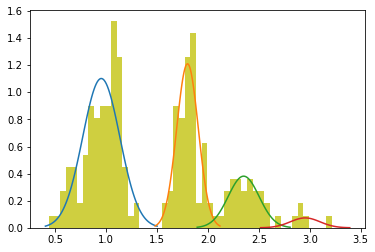

In [13]:
graphs = [1,2,3,4]
for k in graphs:
    mu = gm.means_[k-1]
    variance = gm.covariances_[k-1]
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, gm.weights_[k-1]*stats.norm.pdf(x, mu, sigma))
n, bins, patches = plt.hist(X, 50, density=True, facecolor='y', alpha=0.75)
plt.show()

## 4. Cluster

In [14]:
cluster = pd.read_csv('/Users/jeandre/Desktop/Applied Machine Learning/Post Block Assignemnt 1/Cluster.csv')

In [15]:
cluster

,X,Y,Cluster(0)
0,7.345957,8.085866,2
1,2.480907,6.031914,2
2,9.661872,8.127609,1
3,8.046870,6.995351,1
4,7.038915,5.732423,4
...,...,...,...
395,2.056546,-5.661233,4
396,1.223968,-5.976484,2
397,2.020931,-5.966769,1
398,3.405836,-3.875425,2


In [16]:
X = cluster[list(cluster.columns[0:2])]

In [17]:
counts = cluster["Cluster(0)"].value_counts()
print(counts)
counts = np.asarray(counts)
groups = [2,3,1,4]
weights = []
for index,count in enumerate(counts):
    print("Probability of being in class ",groups[index],"=",count/400)
    weights.append(count/400) #calculate initial weights for use in prior assumptions

2    111
3    100
1     98
4     91
Name: Cluster(0), dtype: int64
Probability of being in class  2 = 0.2775
Probability of being in class  3 = 0.25
Probability of being in class  1 = 0.245
Probability of being in class  4 = 0.2275


In [18]:
# Initial weights is the only assumption made here
#Using mixture.GaussianMixture here again therefore EM again.
gm2 = mixture.GaussianMixture(covariance_type='spherical',n_components=4,tol=0.001,verbose=1,weights_init=weights)


In [19]:
labels = gm2.fit_predict(X)
len(labels)
labels = pd.DataFrame(labels,columns=["labels"])
X = X.merge(labels,left_index=True, right_index=True)
X

Initialization 0
Initialization converged: True


,X,Y,labels
0,7.345957,8.085866,0
1,2.480907,6.031914,0
2,9.661872,8.127609,0
3,8.046870,6.995351,0
4,7.038915,5.732423,0
...,...,...,...
395,2.056546,-5.661233,2
396,1.223968,-5.976484,1
397,2.020931,-5.966769,2
398,3.405836,-3.875425,2


<AxesSubplot:xlabel='X', ylabel='Y'>

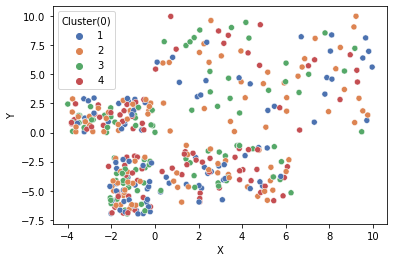

In [20]:
sns.scatterplot(data=cluster, x="X", y="Y", hue="Cluster(0)",palette="deep") # Initial clusters

<AxesSubplot:xlabel='X', ylabel='Y'>

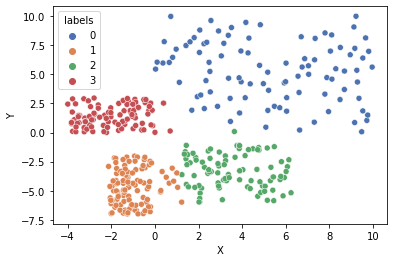

In [21]:
sns.scatterplot(data=X, x="X", y="Y", hue="labels",palette="deep") # Fitted cluster